In [13]:
import cv2
import os
import glob

# Set the directory where your images are located
image_folder = './'
images = [img for img in os.listdir(image_folder) if (img.startswith("splash") & img.endswith(".png"))]
# images = [img for img in os.listdir(image_folder) if (img.startswith("power") and img.endswith(".png"))]
video_name = 'dense.mp4'

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1'
video = cv2.VideoWriter(video_name, fourcc, 5, (width, height))

# Sort the file names if necessary
images.sort()  # Sort the images by name (this is optional and may depend on your naming convention)

# Append the images to the video
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# Release the video writer
cv2.destroyAllWindows()
video.release()

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.constants import G
import yt
import os
from yt.units import pc, kpc

font = {'family': 'serif',
        'weight': 'normal',
        'size': 10,
}

In [2]:
# Constants
G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
G *= (100)**3 / 1000 # to cgs
Number_Density_Fraction = 1.16e-24

In [3]:
# Functions

def Virial_Radius( halo_mass, redshift):
    # Example values
    halo_mass = halo_mass * u.g  # Halo mass
    overdensity = 200  # Overdensity factor

    # Calculate critical density of the universe at given redshift
    critical_density = cosmo.critical_density(redshift)

    # Calculate the virial radius
    # M = (4/3) * pi * R_vir^3 * Delta * rho_c
    # Rearranging for R_vir:
    virial_radius = ((3 * halo_mass) / (4 * np.pi * overdensity * critical_density))**(1/3)

    return virial_radius.value

def Mass_Shells( coord, mass, center, num_bins ):
    # Calculate the distance from the center of mass
    dist = np.sqrt( np.sum( (coord - center)**2, axis=1 ) )

    # Calculate the virial radius
    max_radius = max( dist )

    # Calculate the bin edges
    bin_edges = np.linspace( 0, max_radius, num_bins + 1 )

    # Calculate the mass in each shell
    mass_in_shells, bin_edges = np.histogram( dist, bins=bin_edges, weights=mass )

    # Calculate the mass in each shell
    mass_in_shells = mass_in_shells * u.g

    # Calculate the volume of each shell
    shell_volume = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

    # Calculate the density in each shell
    density_in_shells = mass_in_shells.value / shell_volume

    return density_in_shells, bin_edges

def Center_of_Quan( quan, mass ):
    # Calculate the center of mass
    coq = np.zeros(3)
    for i in range(3):
        coq[i] = np.sum( quan[:,i] * mass ) / np.sum( mass )

    return coq

def Potential( coord, mass ):
    # Calculate the potential energy of the system
    G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
    G = G * (100)**3 / 1000 # to cgs

    potential = 0
    for i in range(len(mass)):
        for j in range(i+1, len(mass)):
            r = np.sqrt( np.sum( (coord[i] - coord[j])**2 ) )
            potential += - G * mass[i] * mass[j] / r
    
    return potential

def Density_In_Beams( mass, density, num_bins, to_number_density=False ):

    if to_number_density:
        density_cal = density / Number_Density_Fraction
        bin_edges = np.logspace( -6, 9, num_bins + 1 )
    else:
        density_cal = density
        bin_edges = np.logspace( -30, -13, num_bins + 1 )

    # Calculate the mass in each beams
    density_in_beams, bin_edges = np.histogram( density_cal, bins=bin_edges, weights=mass )
    density_in_beams_fraction = density_in_beams / np.sum(mass)

    return density_in_beams_fraction, bin_edges

def Read_File( file ):
    # Open the file
    # file = h5py.File(file, 'r')
    
    # Read the file
    scale_factor        = file['Header'].attrs['Time']
    unit_length_cgs     = file['Header'].attrs['UnitLength_In_CGS']
    unit_mass_cgs       = file['Header'].attrs['UnitMass_In_CGS']
    unit_vel_cgs        = file['Header'].attrs['UnitVelocity_In_CGS']

    # Calculate the position and the velocity of the center of mass

    gas_coord   = file['PartType0']['Coordinates'][:]
    gas_vel     = file['PartType0']['Velocities'][:]
    gas_mass    = file['PartType0']['Masses'][:]
    gas_density = file['PartType0']['Density'][:]
    gas_temp    = file['PartType0']['Temperature'][:]

    coord   = gas_coord * scale_factor * unit_length_cgs
    vel     = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
    mass    = gas_mass * unit_mass_cgs
    density = gas_density * unit_mass_cgs / (unit_length_cgs * scale_factor)**3

    # Close the file

    return coord, mass, density, vel, gas_temp

def Speed_of_Sound( temperature, ele_abund ):
    # Constants for air
    gamma = 5/3  # Adiabatic index for idea gas
    R = 8.31  # Specific gas constant for ISM in J/mol·K
    m = 1.67e-3  # Molar mass of ISM in kg/mol
    X_H = 0.76  # Hydrogen mass fraction
    mu = 4 / (1 + 3*X_H + 4*X_H*ele_abund)  # Mean molecular weight of ISM

    # Calculate the speed of sound in the medium
    speed_of_sound = np.sqrt(gamma * R * temperature / (mu * m)) * 100 # in cm/s

    return speed_of_sound

def Mach_Number( velocities, masses, temperature, ele_abund ):
    # Calculate the average velocity
    # If you have masses and want to do a mass-weighted average:
    total_mass = np.sum(masses)
    average_velocity = np.sum(velocities.T * masses, axis=1) / total_mass

    # Calculate the velocity fluctuations
    velocity_fluctuations = velocities - average_velocity

    # If needed, calculate the magnitude of these fluctuations
    velocity_fluctuation_magnitudes = np.linalg.norm(velocity_fluctuations, axis=1)

    # Calculate the speed of sound in the medium
    speed_of_sound = Speed_of_Sound( temperature, ele_abund )

    # Calculate the Mach number for each particle
    mach_numbers = velocity_fluctuation_magnitudes / speed_of_sound

    return mach_numbers, velocity_fluctuation_magnitudes
    

In [4]:
snap_folder = './'
snap_list = [int(snap[9:12]) for snap in os.listdir(snap_folder) if (snap.startswith("snapshot_") & snap.endswith(".hdf5"))]

N_i = min(snap_list)
N_f = max(snap_list) + 1

N_s = 30

Single snapshot section

In [5]:
# Calculate the mach number of the specific snapshots

f = h5py.File( "snapshot_%03d.hdf5" % N_s )

scale_factor        = f['Header'].attrs['Time']
h_factor            = f['Header'].attrs['HubbleParam']
unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']
time = 1/scale_factor - 1

# Particle Type 0
gas_coord   = f['PartType0']['Coordinates'][:] 
gas_vel     = f['PartType0']['Velocities'][:]
gas_mass    = f['PartType0']['Masses'][:]
gas_density = f['PartType0']['Density'][:]
gas_potent  = f['PartType0']['Potential'][:]
gas_temp    = f['PartType0']['Temperature'][:]
gas_intern  = f['PartType0']['InternalEnergy'][:]
gas_electron= f['PartType0']['ElectronAbundance'][:]
gas_smooth  = f['PartType0']['SmoothingLength'][:]
gas_metal   = f['PartType0']['Metallicity'][:]

coord       = gas_coord * scale_factor * unit_length_cgs
mass        = gas_mass * unit_mass_cgs
velocity    = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
density     = gas_density * unit_mass_cgs / (unit_length_cgs * scale_factor)**3
potential   = gas_potent * unit_vel_cgs**2 / scale_factor
internal    = gas_intern * unit_vel_cgs**2
smoothing   = gas_smooth * scale_factor * unit_length_cgs

# Particle Type 1
dm_coord    = f['PartType1']['Coordinates'][:] * scale_factor * unit_length_cgs
dm_mass     = f['PartType1']['Masses'][:] * unit_mass_cgs

time = 1/scale_factor - 1

In [6]:
f['PartType0'].keys()

<KeysViewHDF5 ['CoolingRate', 'Coordinates', 'Density', 'ElectronAbundance', 'GrackleDI', 'GrackleDII', 'GrackleH2I', 'GrackleH2II', 'GrackleHDI', 'GrackleHI', 'GrackleHII', 'GrackleHM', 'GrackleHeI', 'GrackleHeII', 'GrackleHeIII', 'InternalEnergy', 'Masses', 'Metallicity', 'MolecularMassFraction', 'NeutralHydrogenAbundance', 'ParticleChildIDsNumber', 'ParticleIDGenerationNumber', 'ParticleIDs', 'Potential', 'SmoothingLength', 'Temperature', 'Velocities', 'VelocityDivergence', 'VelocityGradient', 'Vorticity']>

In [6]:
ind = np.where( density > 200*cosmo.critical_density(time).value )[0]

coord_over  = coord[ind]
mass_over   = mass[ind]
density_over = density[ind]

COM_1 = Center_of_Quan( coord_over, mass_over )

# Repeat it again
rel_x = coord_over[:, 0] - COM_1[0]
rel_y = coord_over[:, 1] - COM_1[1]
rel_z = coord_over[:, 2] - COM_1[2]

distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
r_offset = 5 * scale_factor * unit_length_cgs
ind = np.where(distance < r_offset)[0]

COM_2 = Center_of_Quan( coord_over[ind], mass_over[ind] )

# Find the final position by finding the maximum density
rel_x = coord_over[:, 0] - COM_2[0]
rel_y = coord_over[:, 1] - COM_2[1]
rel_z = coord_over[:, 2] - COM_2[2]

distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
r_offset = 2.5 * scale_factor * unit_length_cgs
ind = np.where(distance < r_offset)[0]
# COM = coord_over[np.argmax(density_over[ind])]
COM = Center_of_Quan( coord_over[ind], mass_over[ind] )

print("Center of Mass: ", COM/(scale_factor * unit_length_cgs))

# Position and velocity relative to center of mass
rel_x = coord[:, 0] - COM[0]
rel_y = coord[:, 1] - COM[1]
rel_z = coord[:, 2] - COM[2]

# radius within 1 ckpc/h
radius = 150
distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
r_offset = radius * 3.08e18
ind_1 = np.where(distance < r_offset)[0]
print("Search radius: %.3f pc" % (radius))

coord_in_1  = coord[ind_1]
mass_in_1   = mass[ind_1]
vel_in_1    = velocity[ind_1]
temp_in_1   = gas_temp[ind_1]
ele_abund_in_1 = gas_electron[ind_1]

# Calculate the total energy respect to the center of mass
distance = np.logspace(-2, 2, 200)

gas_distance = np.sqrt( np.sum( (coord - COM)**2, axis=1 ) )
dm_distance  = np.sqrt( np.sum( (dm_coord - COM)**2, axis=1 ) )

Center of Mass:  [-1.11502103 -0.06999729  0.84853428]
Search radius: 150.000 pc


In [16]:
print("Plot area: ")
for i in range(3):
    com_i = COM[i] / 3.08e18
    if i == 0:
        print("  %2.6e   %2.6e" % (com_i - r_offset*2/3.08e18, com_i + r_offset*2/3.08e18))
    else:
        print("  %2.6e   %2.6e" % (com_i - r_offset/3.08e18, com_i + r_offset/3.08e18))

print("Center of Mass: ")
for i in range(3):
    print("  %2.6e" % (COM[i] / 3.08e18))

Plot area: 
  -3.808191e+02   2.191809e+02
  -1.550736e+02   1.449264e+02
  -8.849644e+01   2.115036e+02
Center of Mass: 
  -8.081908e+01
  -5.073552e+00
  6.150356e+01


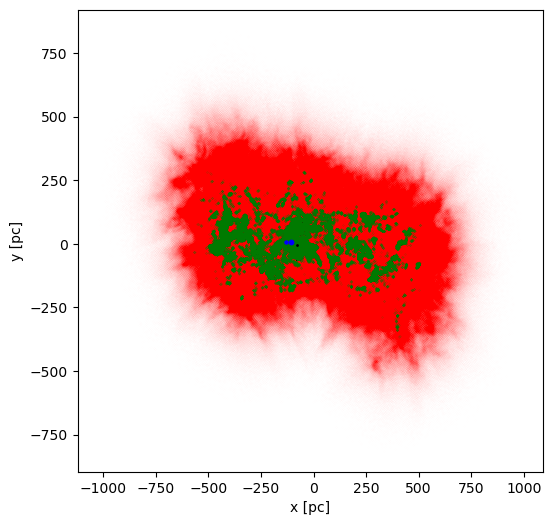

In [10]:
x_lim = y_lim = 10 * scale_factor * unit_length_cgs / (3.08e18)

ind = np.where( density > 200*cosmo.critical_density(time).value )[0]
ind_dense = np.argmax(density)

plt.figure( figsize=(6,6) )
plt.scatter( coord[:,0] / (3.08e18), coord[:,1] / (3.08e18), s=0.00001, c='r' )
plt.scatter( coord[ind,0] / (3.08e18), coord[ind,1] / (3.08e18), s=0.01, c='g' )
plt.scatter( COM_1[0] / (3.08e18), COM_1[1] / (3.08e18), s=10, c='b' )
plt.scatter( COM_2[0] / (3.08e18), COM_2[1] / (3.08e18), s=5, c='b' )
plt.scatter( COM[0] / (3.08e18), COM[1] / (3.08e18), s=1, c='black' )

plt.xlabel('x [pc]')
plt.ylabel('y [pc]')

plt.show()

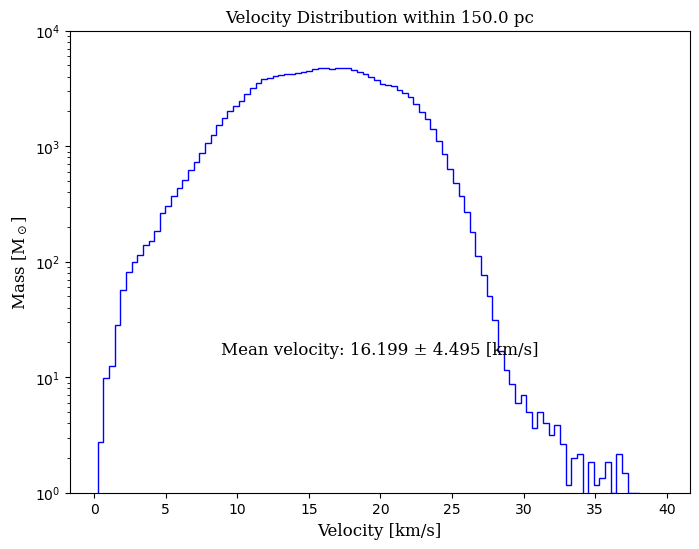

In [25]:
# Calculate the velocity distribution within r = 150 pc
plt.figure( figsize=(8,6) )
plt.hist( np.linalg.norm(vel_in_1, axis=1)/1e5, bins=100, weights=mass_in_1/unit_mass_cgs*1e10, histtype='step', color='blue' )
mean_vel = np.mean(np.linalg.norm(vel_in_1, axis=1)/1e5)
std_vel = np.std(np.linalg.norm(vel_in_1, axis=1)/1e5)

plt.text(0.5, 0.3, r'Mean velocity: %.3f ± %.3f [km/s]' % (mean_vel, std_vel), transform=plt.gca().transAxes, horizontalalignment='center', fontdict=font)
plt.xlabel('Velocity [km/s]', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.yscale('log')
plt.ylim(1e0, 1e4)
plt.title('Velocity Distribution within %.1f pc' % (r_offset/3.08e18), fontdict=font)

plt.show()

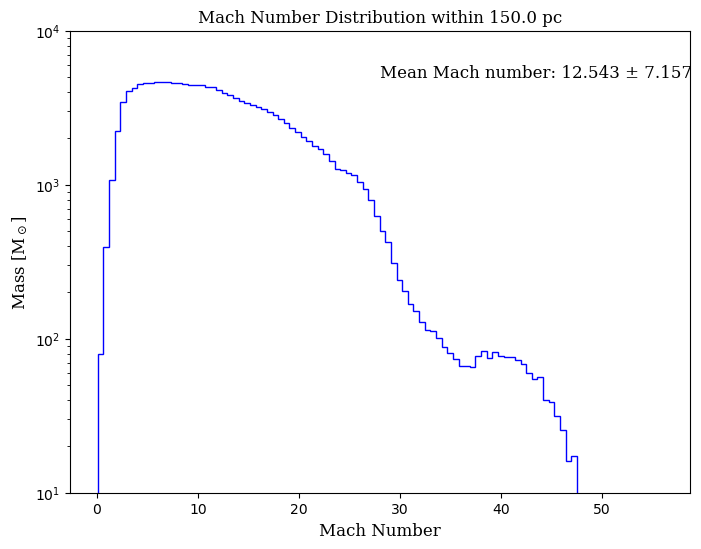

In [26]:
# Convert the velocity to Mach number
mach_numbers, velocity_fluctuation_magnitudes = Mach_Number( vel_in_1, mass_in_1, temp_in_1, gas_electron[ind_1] )
mean_mach = np.mean(mach_numbers)
std_mach = np.std(mach_numbers)

plt.figure( figsize=(8,6) )
plt.hist( mach_numbers, bins=100, weights=mass_in_1/unit_mass_cgs*1e10, histtype='step', color='blue' )
plt.text(0.5, 0.9, r'Mean Mach number: %.3f ± %.3f' % (mean_mach, std_mach), transform=plt.gca().transAxes, fontdict=font)

plt.xlabel('Mach Number', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.yscale('log')
plt.ylim(1e1, 1e4)
plt.title('Mach Number Distribution within %.1f pc' % (r_offset/3.08e18), fontdict=font)

plt.show()


In [27]:
# althernative method
ind = np.where( density > 5000*cosmo.critical_density(time).value )[0]
velocities = velocity[ind]
positions = coord[ind]
masses = mass[ind]
temperature = gas_temp[ind]
ele_abund = gas_electron[ind]

# Constants
gamma = 5 / 3
k_B = 1.380649e-23  # Boltzmann constant in J/K
m_p = 1.6726219e-27  # Proton mass in kg
X_H = 0.76  # Hydrogen mass fraction
mu = 4 / (1 + 3*X_H + 4*X_H*ele_abund)  # Mean molecular weight of ISM

# Compute speed of sound
speed_of_sound = np.sqrt(gamma * k_B * temperature / (mu * m_p)) * 100

# Compute Mach number
velocity_magnitude = np.linalg.norm(velocities, axis=1)
mach_number = velocity_magnitude / speed_of_sound

# Compute velocity dispersion (simple finite difference approximation)
from scipy.spatial import KDTree
tree = KDTree(coord)    # Create KDTree for fast neighbor search
velocity_disper = np.zeros(np.shape(velocities)[0])
for i in range(np.shape(velocities)[0]):
    distances, indices = tree.query(positions[i], 32)  # Find neighbors
    neighbors = velocity[indices[1:]]  # Exclude the point itself
    local_velocities = velocities[i] - neighbors
    squared_deviations = np.sum(local_velocities**2, axis=1)
    velocity_disper[i] = np.sqrt(np.mean(squared_deviations))

# Example analysis
print("Mach Number:", mach_number)
print("Velocity Dispersion:", velocity_disper/1e5)

Mach Number: [18.904238 12.301476 13.511539 ...  5.648463  5.637827  5.558272]
Velocity Dispersion: [8.56720562 7.13646438 6.47283063 ... 0.34362043 0.36607555 0.30168996]


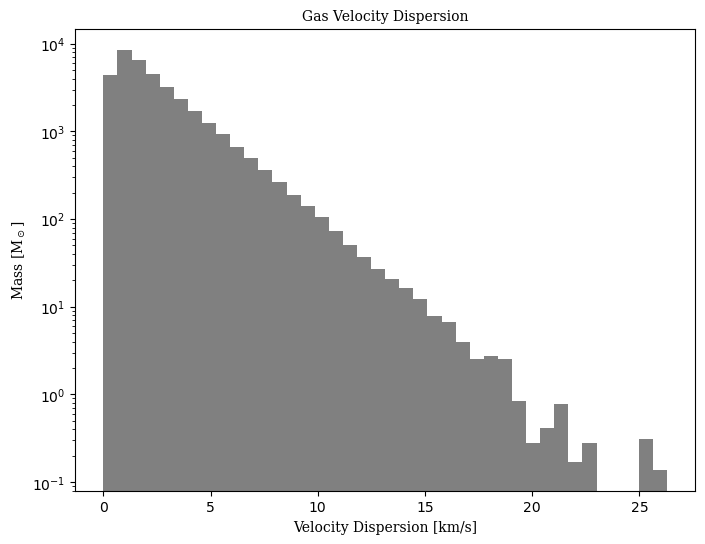

In [ ]:
plt.figure( figsize=(8,6), dpi=100 )
plt.hist( velocity_disper / 100000, bins=40, weights=masses/unit_mass_cgs*1e10, color='grey', fill=True )

plt.title('Gas Velocity Dispersion', fontdict=font)
plt.xlabel('Velocity Dispersion [km/s]', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.yscale('log')

plt.show()

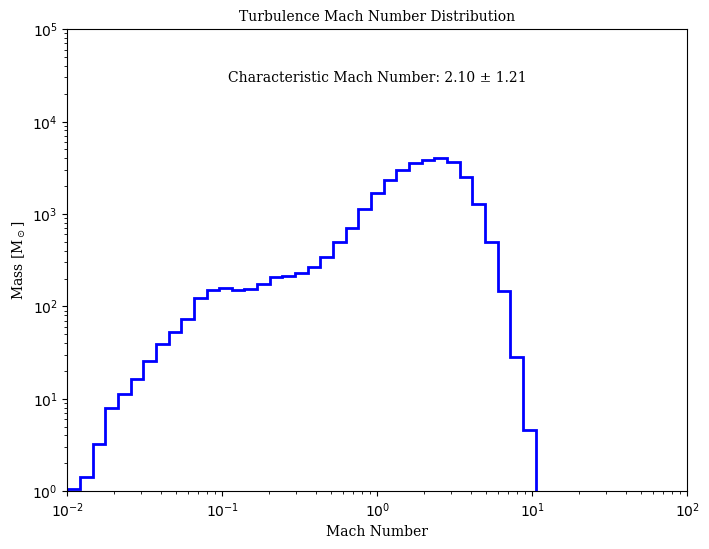

In [28]:
font = {'family': 'serif',
        'weight': 'normal',
        'size': 10,
}

mach_number_of_disperse = velocity_disper / speed_of_sound
plt.figure( figsize=(8,6), dpi=100 )
hist_value, bin_edges = np.histogram( mach_number_of_disperse, bins=np.logspace(-2, 2, 50) )
mean_value = np.mean( mach_number_of_disperse )
std_value = np.std( mach_number_of_disperse )

plt.hist( mach_number_of_disperse, bins=np.logspace(-2, 2, 50), weights=masses/unit_mass_cgs*1e10, histtype='step', color='b', linewidth=2 )

# print the mach number with the largest population in the histogram
plt.text( 1, 3e4, 'Characteristic Mach Number: %4.2f ± %4.2f' % (mean_value, std_value), verticalalignment='center', horizontalalignment='center', fontdict=font )

plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1e5)
plt.xlim(1e-2, 1e2)
plt.xlabel('Mach Number', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.title('Turbulence Mach Number Distribution', fontdict=font)

plt.show()

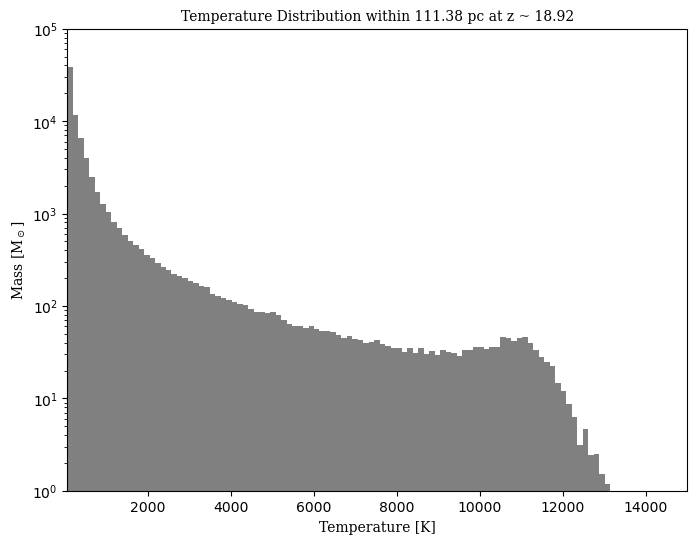

In [ ]:
# Plot temperature distribution

# Plot the figure
plt.figure( figsize=(8, 6), dpi= 100 )

plt.hist( gas_temp[ind_1], bins=100, weights=mass[ind_1]/unit_mass_cgs*1e10,color='grey' )
# plt.plot( bin_edges[0:beams], fraction*np.sum(mass), label='%9.1f M$_\odot$' % 0.1 )
# plt.xscale('log')
plt.yscale('log')
plt.ylim( 1, 1e5)
plt.xlim( np.min(gas_temp[ind_1]), 1.5e4)

# plt.text( 1e-6, 3e3, 'Mean Density: %.2e cm$^{-3}$' % mean_density, fontdict=font )

plt.xlabel('Temperature [K]', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.title('Temperature Distribution within %.2f pc at z ~ %.2f' % (r_offset, time), fontdict=font)

plt.show()

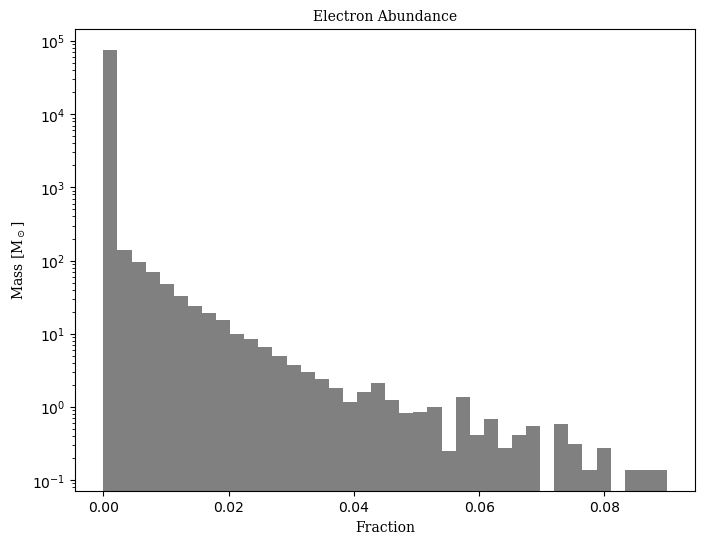

In [ ]:
plt.figure( figsize=(8, 6), dpi= 100 )
plt.hist( f['PartType0']['ElectronAbundance'][:][ind_1], bins=40, weights=mass[ind_1]/unit_mass_cgs*1e10, color='grey' )

plt.title('Electron Abundance', fontdict=font)
plt.xlabel('Fraction', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.yscale('log')

plt.show()

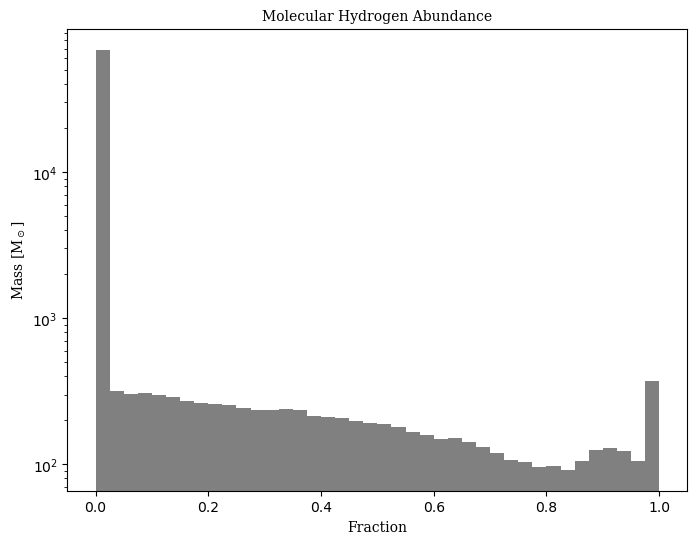

In [ ]:
plt.figure( figsize=(8, 6), dpi= 100 )
plt.hist( f['PartType0']['MolecularMassFraction'][:][ind_1], bins=40, weights=mass[ind_1]/unit_mass_cgs*1e10, color='grey')

plt.title('Molecular Hydrogen Abundance', fontdict=font)
plt.xlabel('Fraction', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.yscale('log')

plt.show()

In [ ]:
mean_density = np.mean( density * mass ) / np.sum(mass)
std_density  = np.std( density * mass ) / np.sum(mass)

In [12]:
# Plot the energy fractions

total_energy        = []
potential_energy    = []
kinetic_energy      = []
internel_energy     = []
total_mass          = []
gas_mass_set        = []

# Do at the very first
gas_ind = np.where( gas_distance < distance[0] * scale_factor * unit_length_cgs )[0]
dm_ind  = np.where( dm_distance < distance[0] * scale_factor * unit_length_cgs )[0]
total_mass.append( np.sum( mass[gas_ind] ) + np.sum( dm_mass[dm_ind]) )
gas_mass_set.append( np.sum( mass[gas_ind] ) )

for d in distance[1:]:
    d *= (scale_factor * unit_length_cgs)
    # Find the gas and dm particles within the distance
    gas_ind = np.where( gas_distance < d )[0]
    dm_ind  = np.where( dm_distance < d )[0]

    total_mass.append( np.sum( mass[gas_ind] ) + np.sum( dm_mass[dm_ind] ) )
    gas_mass_set.append( np.sum( mass[gas_ind] ) )

    # Calculate the potential_energy
    P = np.sum( potential[gas_ind]*mass[gas_ind] )
    potential_energy.append(P)

    # Calculate the kinetic_energy
    # Calculate the velocity of the center of mass
    com_vx, com_vy, com_vz = Center_of_Quan( velocity[gas_ind], mass[gas_ind] )
    rel_vx, rel_vy, rel_vz = gas_vel[:,0] - com_vx, gas_vel[:,1] - com_vy, gas_vel[:,2] - com_vz
    rel_v = np.sqrt(rel_vx**2 + rel_vy**2 + rel_vz**2)
    Ek = np.sum(1/2*mass[gas_ind]*rel_v[gas_ind]**2)

    # Calculate the internel_energy
    Eu = np.sum( internal[gas_ind] * mass[gas_ind] )

    # Use the above values to obtain the total energy
    E = -P + Ek + Eu

    # Record the value across snapshots
    total_energy.append(E)
    potential_energy.append(P)
    kinetic_energy.append(-Ek/P)
    internel_energy.append(-Eu/P)

/tmp/ipykernel_19978/2884214659.py:46: RuntimeWarning: invalid value encountered in scalar divide
  coq[i] = np.sum( quan[:,i] * mass ) / np.sum( mass )
/tmp/ipykernel_19978/2676851764.py:45: RuntimeWarning: invalid value encountered in scalar divide
  kinetic_energy.append(-Ek/P)


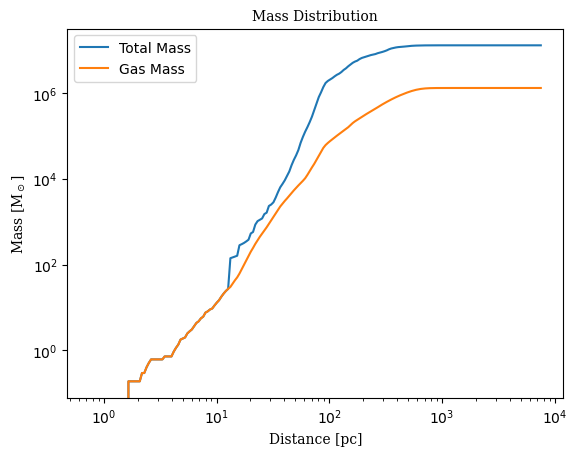

In [13]:
plt.plot( distance * scale_factor * unit_length_cgs / 3.08e18, total_mass/unit_mass_cgs*1e10, label='Total Mass')
plt.plot( distance * scale_factor * unit_length_cgs / 3.08e18, gas_mass_set/unit_mass_cgs*1e10, label='Gas Mass')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance [pc]', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.title('Mass Distribution', fontdict=font)
plt.legend()

plt.show()

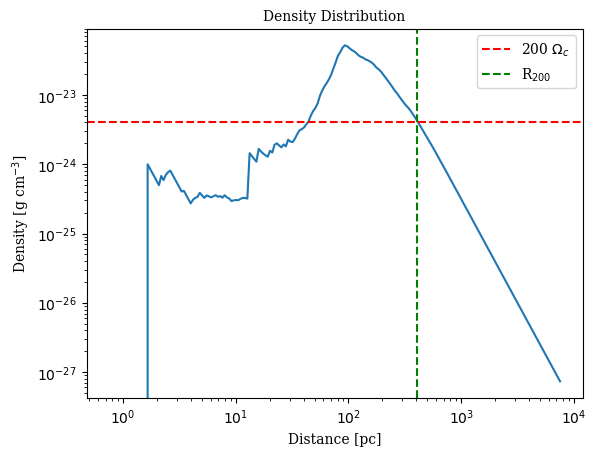

In [14]:
density_distance = total_mass / (4/3 * np.pi * (distance*scale_factor*unit_length_cgs)**3)

# Find the point where the density drops below 200 times the critical density
ind = np.where( density_distance > 200*cosmo.critical_density(time).value )[0][-1]

plt.plot( distance * scale_factor * unit_length_cgs / 3.08e18, density_distance ) 
plt.axhline( 200 * cosmo.critical_density(time).value, color='r', linestyle='--', label='200 $\Omega_c$')
plt.axvline( distance[ind] * scale_factor * unit_length_cgs / 3.08e18, color='g', linestyle='--', label='R$_{200}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance [pc]', fontdict=font)
plt.ylabel('Density [g cm$^{-3}$]', fontdict=font)
plt.title('Density Distribution', fontdict=font)
plt.legend(prop=font)

plt.show()

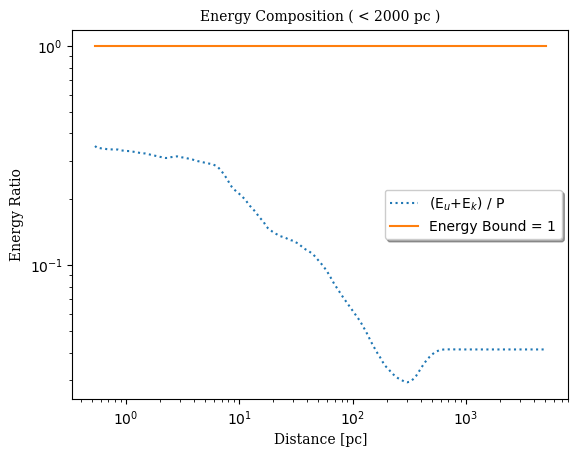

In [ ]:
# Plot the energy profile
fig, ax = plt.subplots()
ax.plot(distance[1:]* scale_factor * 1000, np.array(kinetic_energy) + np.array(internel_energy)    , ':'   , label='(E$_u$+E$_k$) / P')
ax.plot(distance[1:]* scale_factor * 1000, [1]*len(internel_energy), label='Energy Bound = 1' )

legend = ax.legend(loc=7, shadow=True)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(0.1, 10)
plt.xlabel('Distance [pc]', fontdict=font)
plt.ylabel('Energy Ratio', fontdict=font)

plt.title('Energy Composition ( < 2000 pc )', fontdict=font)
plt.show()

In [ ]:
def fft_comp(ds, irho, iu, nindex_rho, level, low, delta):
    cube = ds.covering_grid(level, left_edge=low, dims=delta, fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[
        0 : nx // 2 + 1, 0 : ny // 2 + 1, 0 : nz // 2 + 1
    ]
    ru = 8.0 * ru / (nx * ny * nz)

    return np.abs(ru) ** 2

box_len = [32, 8]
for i in box_len:

    print("Box_length: %d pc" % (i*scale_factor*unit_length_cgs/3.08e18))
    len = i
    CM = COM / (scale_factor * unit_length_cgs)

    bbox = [[-len + CM[0], len + CM[0]], [-len + CM[1], len + CM[1]], [-len + CM[2], len + CM[2]]]
    unit_base = {
        "length": (scale_factor * unit_length_cgs / 3.08e21, "kpc"),
        "velocity": (1.0, "km/s"),
        "mass": (unit_mass_cgs / 1.933e33, "Msun"),
    }

    ds = yt.load("./snapshot_%03d.hdf5" % (N_s), unit_base=unit_base, bounding_box=bbox)
    ds.force_periodicity()

    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = 9
    low = ds.domain_left_edge
    dims = 2**max_level

    nx = ny = nz = dims

    nindex_rho = 1.0 / 3.0

    Kk = np.zeros((nx // 2 + 1, ny // 2 + 1, nz // 2 + 1))

    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"), ("gas", "velocity_z")]:
        Kk += 0.5 * fft_comp(
            ds, ("gas", "density"), vel, nindex_rho, max_level, low, dims
        )

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx) * nx / L[0]
    ky = np.fft.rfftfreq(ny) * ny / L[1]
    kz = np.fft.rfftfreq(nz) * nz / L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0 / L)
    kmax = np.min(0.5 * dims / L)

    kbins = np.arange(kmin, kmax, kmin)
    N = np.shape(kbins)[0]

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(np.shape(ncount)[0] - 1)

    for n in range(1, np.shape(ncount)[0]):
        E_spectrum[n - 1] = np.sum(Kk.flat[whichbin == n])

    k = 0.5 * (kbins[0 : N - 1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N] / (kmin)

    kmax = k[int(np.shape(k)[0] / 2)]
    Emax = E_spectrum[int(np.shape(k)[0] / 2)]

    # output the result to txt file
    np.savetxt("spectrum_%03d.txt" % len, np.column_stack((k, E_spectrum)))

yt : [INFO     ] 2024-06-24 18:50:14,745 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-06-24 18:50:14,774 Parameters: current_time              = 0.05091268337460699
yt : [INFO     ] 2024-06-24 18:50:14,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-06-24 18:50:14,776 Parameters: domain_left_edge          = [-6.90257481 -4.22615525 -4.05061312]
yt : [INFO     ] 2024-06-24 18:50:14,776 Parameters: domain_right_edge         = [1.09742519 3.77384475 3.94938688]
yt : [INFO     ] 2024-06-24 18:50:14,776 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-06-24 18:50:14,777 A bounding box was explicitly specified, so we are disabling periodicity.


yt : [INFO     ] 2024-06-24 18:50:14,796 Allocating for 6.636e+06 particles


Box_length: 301 pc


Initializing coarse index : 100%|██████████| 25/25 [00:00<00:00, 41.92it/s]
yt : [INFO     ] 2024-06-24 18:50:15,407 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s]
Interpolating SPH field ('PartType0', 'Density'): 9500000it [00:21, 444287.49it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_x'): 9500000it [00:21, 443011.93it/s]
Interpolating SPH field ('PartType0', 'Density'): 9500000it [00:21, 444705.17it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_y'): 9500000it [00:21, 441455.36it/s]
Interpolating SPH field ('PartType0', 'Density'): 9500000it [00:21, 445221.14it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_z'): 9500000it [00:21, 441483.58it/s]


In [7]:
spectrum_file = [f for f in os.listdir() if f.startswith("spectrum")]
spectrum_scale = [int(f.split("_")[1].split(".")[0]) for f in spectrum_file]
# sort by scale from small to large
spectrum_scale.sort()

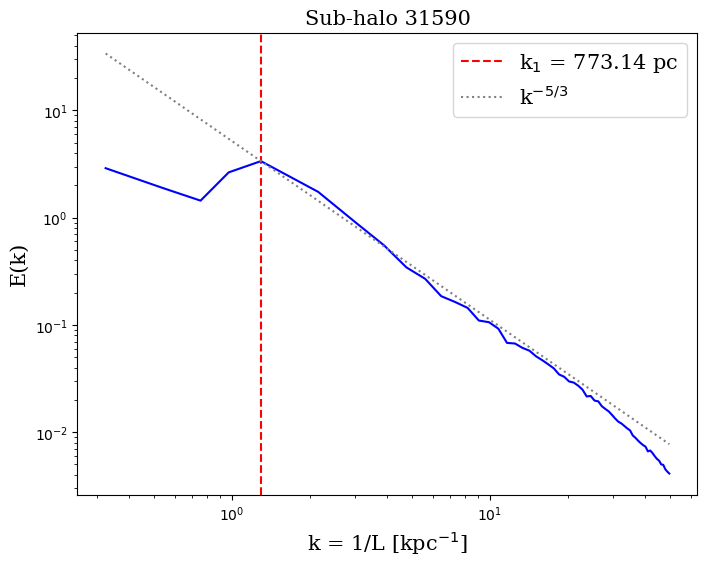

In [11]:
font = {'family': 'serif',
        'weight': 'normal',
        'size': 15,
}

# load data
data = np.loadtxt("spectrum_%03d.txt" % spectrum_scale[0])
k = data[:, 0]
E_spectrum = data[:, 1]
k /= (scale_factor * unit_length_cgs / 3.08e21)

offset = k[0]
scale = spectrum_scale[0]
for i in spectrum_scale[1:]:
    data = np.loadtxt("spectrum_%03d.txt" % i)
    k_new = data[:, 0] / (scale_factor * unit_length_cgs / 3.08e21)
    E_new = data[:, 1]
    find_offset = np.where(k_new < offset)[0]

    if np.shape(find_offset)[0] == 0:
        continue
    else:
        find_offset = find_offset[-1]

    k = np.concatenate( (k_new[:find_offset], k) )
    E_spectrum = np.concatenate( (E_new[:find_offset], E_spectrum) )
    offset = k[0]

k_off = np.where(k > 50)[0][0]
k = k[:k_off]
E_spectrum = E_spectrum[:k_off]

kmax = k[np.argmax(E_spectrum[2:]) + 2]
Emax = E_spectrum[np.argmax(E_spectrum[2:]) + 2]

plt.figure( figsize=(8, 6), dpi= 100 )

plt.axvline(kmax, color="r", linestyle="--", label=r"k$_1$ = %.2f pc" % (1e3/kmax))
plt.loglog(k[:k_off], E_spectrum[:k_off], c='b')
plt.loglog(k[:k_off], Emax * (k[:k_off] / kmax) ** (-5.0 / 3.0), ls=":", color="0.5", label=r"k$^{-5/3}$")
plt.xlabel(r"k = 1/L [kpc$^{-1}$]", fontdict=font)
plt.ylabel(r"E(k)", fontdict=font)
plt.xticks( fontsize=15 )
plt.yticks( fontsize=15 )

plt.legend(prop=font)
plt.title("Sub-halo 31590", fontdict=font)
plt.show()

In [12]:
from yt.units import pc, kpc

range_length = 30
len = range_length * scale_factor * unit_length_cgs / 3.08e21
CM = COM / (scale_factor * unit_length_cgs)

bbox = [[-len + CM[0], len + CM[0]], [-len + CM[1], len + CM[1]], [-len + CM[2], len + CM[2]]]
unit_base = {
    "length": (scale_factor * unit_length_cgs / 3.08e21, "kpc"),
    "velocity": (1.0, "km/s"),
    "mass": (unit_mass_cgs / 1.933e33, "Msun"),
}

ds = yt.load("./snapshot_%03d.hdf5" % (N_s), unit_base=unit_base, bounding_box=bbox)

yt : [INFO     ] 2024-07-27 20:09:17,924 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-07-27 20:09:17,970 Parameters: current_time              = 0.049009036794660774
yt : [INFO     ] 2024-07-27 20:09:17,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-27 20:09:17,971 Parameters: domain_left_edge          = [-3.2894845  -2.24446077 -1.3259292 ]
yt : [INFO     ] 2024-07-27 20:09:17,971 Parameters: domain_right_edge         = [1.05944245 2.10446618 3.02299775]
yt : [INFO     ] 2024-07-27 20:09:17,972 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-07-27 20:09:17,972 A bounding box was explicitly specified, so we are disabling periodicity.


yt : [INFO     ] 2024-07-27 20:09:21,111 Allocating for 8.782e+06 particles
Initializing coarse index : 100%|██████████| 33/33 [00:00<00:00, 108.89it/s]
yt : [INFO     ] 2024-07-27 20:09:21,435 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 33/33 [00:01<00:00, 21.67it/s]
yt : [INFO     ] 2024-07-27 20:09:23,379 xlim = -3.289485 1.059442
yt : [INFO     ] 2024-07-27 20:09:23,381 ylim = -2.244461 2.104466
yt : [INFO     ] 2024-07-27 20:09:23,381 xlim = -3.289485 1.059442
yt : [INFO     ] 2024-07-27 20:09:23,382 ylim = -2.244461 2.104466
yt : [INFO     ] 2024-07-27 20:09:23,400 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000
yt : [INFO     ] 2024-07-27 20:09:34,511 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000
yt : [INFO     ] 2024-07-27 20:09:47,506 Making a fixed resolution buffer of (('gas', 'density')) 62 by 62



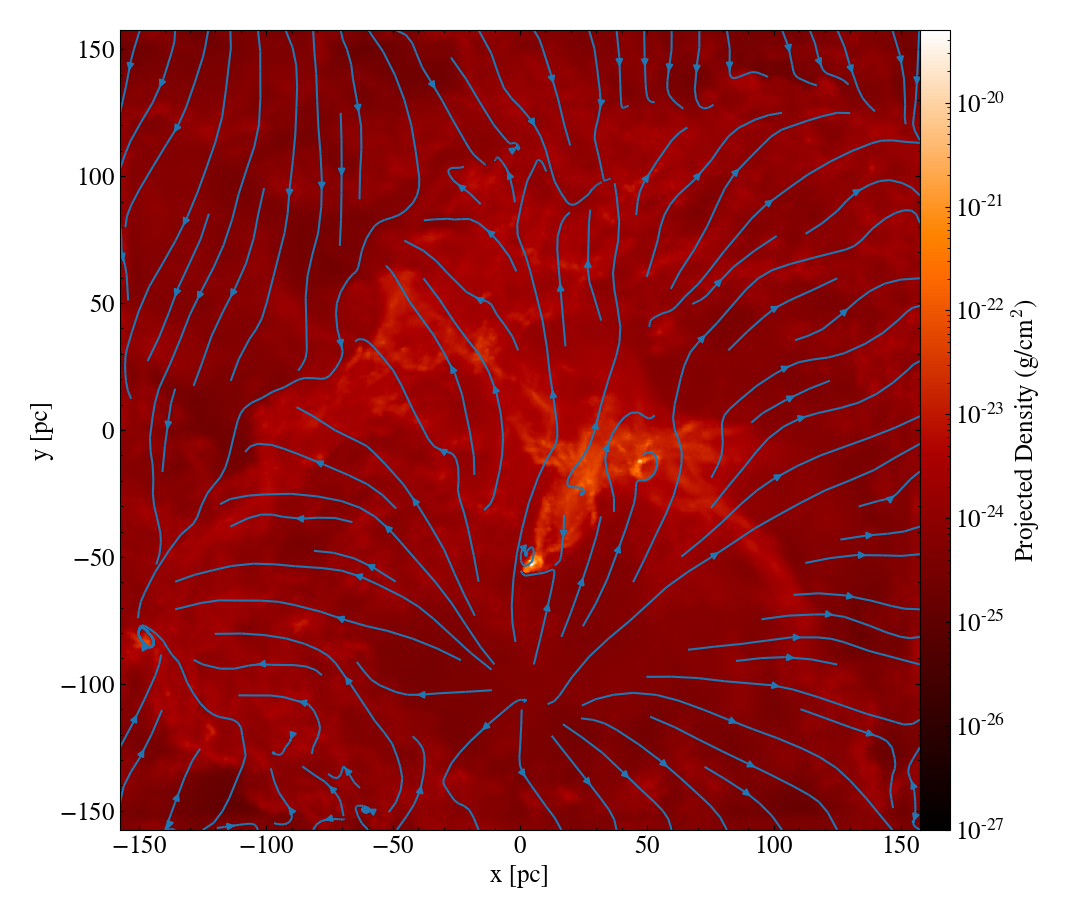

In [13]:
# Plot a projection plot with velocity streamlines

prj = yt.ProjectionPlot(
    ds,
    "z",
    ('gas', 'density'),
    center = CM,
    # width = 300 * pc,
    width = 60 * scale_factor * unit_length_cgs / 3.08e21,
    weight_field=('gas', 'density'),
    buff_size=(1000, 1000),
)
zmin = 1e-27
zmax = 5e-20
# Set the colorbar limits
prj.set_zlim(("gas", "density"), zmin, zmax)
prj.set_colorbar_label(("gas", "density"), "Projected Density (g/cm$^{2}$)")
prj.set_xlabel("x [pc]")
prj.set_ylabel("y [pc]")

prj.set_cmap(field=("gas", "density"), cmap="RED TEMPERATURE")
prj.annotate_streamlines(("gas", "velocity_x"), ("gas", "velocity_y"))
prj.show()

In [ ]:
mean_density = np.sum(mass_in_1) / (4/3 * np.pi * (2.5 * scale_factor * unit_length_cgs)**3) / Number_Density_Fraction
std_density = np.std(density[ind_1] / Number_Density_Fraction)

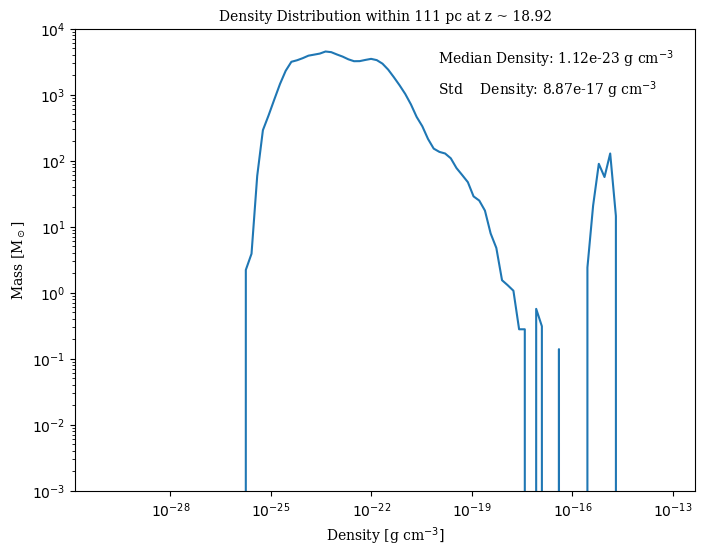

In [ ]:
# Calculate the mass in each shell
beams = 100
r_offset = radius * scale_factor * unit_length_cgs / 3.08e18

fraction, bin_edges = Density_In_Beams( mass_in_1, density[ind_1], beams, 0 )

# Calculate the mean density of the snapshot

# mean_density = np.sum(mass_in_1) / (4/3 * np.pi * (1 * scale_factor * unit_length_cgs)**3)
mean_density = np.median(density[ind_1])
std_density = np.std(density[ind_1])

# Plot the figure
plt.figure( figsize=(8, 6), dpi= 100 )

plt.plot( bin_edges[0:beams], fraction*np.sum(mass_in_1) / unit_mass_cgs * 1e10, label='%9.1f M$_\odot$' % 0.1 )
# plt.plot( bin_edges[0:beams], fraction*np.sum(mass), label='%9.1f M$_\odot$' % 0.1 )
plt.xscale('log')
plt.yscale('log')
plt.ylim( 1e-3, 1e4)

plt.text( 1e-20, 3e3, 'Median Density: %.2e g cm$^{-3}$' % mean_density, fontdict=font )
plt.text( 1e-20, 1e3, 'Std    Density: %.2e g cm$^{-3}$' % std_density, fontdict=font )

plt.xlabel('Density [g cm$^{-3}]$', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.title('Density Distribution within %d pc at z ~ %.2f' % (r_offset, time), fontdict=font)

plt.show()

All snapshot sections

In [ ]:
# Calculate the accretion rate
mass_set = []
time_set = []
com_set = []
com_1_set = []

# Calculate the spin parameter
spin_set = []
r_half_set = []

for i in range(N_i, N_f):
    coord, mass, density, velocity, gas_temp = Read_File( "snapshot_%03d.hdf5" % i )

    time = 1/scale_factor - 1
    ind = np.where( density > 200*cosmo.critical_density(time).value )[0]

    coord_over  = coord[ind]

    # COM = coord[np.argmax(density)]
    COM = Center_of_Quan( coord_over, mass[ind] )

    # Repeat it again
    rel_x = coord[ind, 0] - COM[0]
    rel_y = coord[ind, 1] - COM[1]
    rel_z = coord[ind, 2] - COM[2]

    distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
    r_offset = 2 * scale_factor * unit_length_cgs
    ind = np.where(distance < r_offset)[0]

    COM = Center_of_Quan( coord_over[ind], mass[ind] )

    # Position and velocity relative to center of mass
    rel_x = coord[:, 0] - COM[0]
    rel_y = coord[:, 1] - COM[1]
    rel_z = coord[:, 2] - COM[2]

    # radius within 2.5 ckpc/h
    distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
    r_offset = 2.5 * scale_factor * unit_length_cgs
    ind = np.where(distance[ind] < r_offset)[0]

    M_in_5 =  mass[ind]
    coord_5 = coord[ind]
    vx, vy, vz = velocity[:,0], velocity[:,1], velocity[:,2]

    M = np.sum(M_in_5)

    # Center of mass
    CM_x = np.sum(coord_5[:, 0] * M_in_5) / M
    CM_y = np.sum(coord_5[:, 1] * M_in_5) / M
    CM_z = np.sum(coord_5[:, 2] * M_in_5) / M

    # Position and velocity relative to center of mass
    rel_x = coord[:, 0] - CM_x
    rel_y = coord[:, 1] - CM_y
    rel_z = coord[:, 2] - CM_z
    rel_vx = vx - np.mean(vx)
    rel_vy = vy - np.mean(vy)
    rel_vz = vz - np.mean(vz)

    # Angular momentum for each particle
    lx = rel_y * rel_vz - rel_z * rel_vy
    ly = rel_z * rel_vx - rel_x * rel_vz
    lz = rel_x * rel_vy - rel_y * rel_vx

    # Total angular momentum
    Lx = np.sum(lx * mass)
    Ly = np.sum(ly * mass)
    Lz = np.sum(lz * mass)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)

    # radius within 0.2 ckpc/h
    distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
    r_offset = 0.2 * scale_factor * unit_length_cgs
    ind = np.where(distance < r_offset)[0]

    M_in_1 = np.sum( mass[ind] )

    mass_set.append( M_in_1 )
    time_set.append( 1/scale_factor - 1 )

    # Assuming you have the virial radius R
    # R = half_mass_radius( mass_in_shells, num_bins, bins )
    halo_mass = M + np.sum( f['PartType1']['Masses'][:] ) * unit_mass_cgs
    R = Virial_Radius( halo_mass, 1/scale_factor-1 )

    # Circular velocity at R
    V = np.sqrt(G * M / R)

    # Spin parameter
    lambda_spin = L / (np.sqrt(2) * M * R * V)

    spin_set.append( lambda_spin )
    r_half_set.append( R / 3.08e21 )

/tmp/ipykernel_2022696/2561826035.py:50: RuntimeWarning: invalid value encountered in scalar divide
  CM_x = np.sum(coord_5[:, 0] * M_in_5) / M
/tmp/ipykernel_2022696/2561826035.py:51: RuntimeWarning: invalid value encountered in scalar divide
  CM_y = np.sum(coord_5[:, 1] * M_in_5) / M
/tmp/ipykernel_2022696/2561826035.py:52: RuntimeWarning: invalid value encountered in scalar divide
  CM_z = np.sum(coord_5[:, 2] * M_in_5) / M


In [ ]:
fig, ax1 = plt.subplots()

# ax2 = ax1.twinx()
ax1.plot( time_set , spin_set, 'g-' )
ax1.invert_xaxis()
# ax2.plot( time_set , np.array(r_half_set) / 3.08e21, 'b-' )
# ax2.invert_xaxis()

ax1.set_xlabel('Redshift', fontdict=font)
ax1.set_ylabel('Spin parameter', color='g', fontdict=font)
# ax2.set_ylabel('Virial radius [kpc]', color='b')

plt.title('Spin Parameter', fontdict=font)
plt.show()

In [ ]:
# calculate the mass accretion rate
mass_set = np.array( mass_set )
time_set = np.array( time_set )
phys_time_set = []
rate = []

phys_time_set.append( cosmo.age(time_set[0]).value * 1e9 )
for i in range(1, len(mass_set)):
    phys_time_set.append( cosmo.age(time_set[i]).value * 1e9 )
    rate.append( (mass_set[i] - mass_set[i-1]) / (phys_time_set[i] - phys_time_set[i-1]) )

In [ ]:
# Plot the accretion rate
fig, ax1 = plt.subplots()

ax1.plot( time_set[1:] , rate / unit_mass_cgs, 'b-' )
ax1.invert_xaxis()

ax1.set_xlabel('Redshift', fontdict=font)
ax1.set_ylabel('Rate [M$_\odot$ yr$^{-1}$]', color='b', fontdict=font)

plt.title('Accretion Rate (< 1 ckpc/h)', fontdict=font)
plt.show()

In [9]:
# Plot the phase diagram of density, temperature, and molecular hydrogen fraction across all snapshots

range_length = 30
len = range_length * scale_factor * unit_length_cgs / 3.08e21
CM = COM / (scale_factor * unit_length_cgs)

bbox = [[-len + CM[0], len + CM[0]], [-len + CM[1], len + CM[1]], [-len + CM[2], len + CM[2]]]
unit_base = {
    "length": (scale_factor * unit_length_cgs / 3.08e21, "kpc"),
    "velocity": (1.0, "km/s"),
    "mass": (unit_mass_cgs / 1.933e33, "Msun"),
}

ds = yt.load("./snapshot_%03d.hdf5" % (N_s), unit_base=unit_base, bounding_box=bbox)
ad = ds.all_data()
plot = yt.PhasePlot(
    ad, ("gas", "density"), ("gas", "temperature"), ("PartType0", "MolecularMassFraction"), fontsize=30, 
)
plot.set_cmap(("PartType0", "MolecularMassFraction"), "GnBu")
plot.set_colorbar_label(("PartType0", "MolecularMassFraction"), "Hydrogen Molecular Fraction")
plot.set_xlim(5e-30, 5e-18)
plot.set_ylim(10, 15000)
plot.set_zlim("MolecularMassFraction", 1e-4, 1)

plot.annotate_title("Sub-halo 31590")
plot.save("phase_plot.png")
    

yt : [INFO     ] 2024-07-27 20:30:14,749 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-07-27 20:30:14,787 Parameters: current_time              = 0.049009036794660774
yt : [INFO     ] 2024-07-27 20:30:14,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-27 20:30:14,788 Parameters: domain_left_edge          = [-3.2894845  -2.24446077 -1.3259292 ]
yt : [INFO     ] 2024-07-27 20:30:14,789 Parameters: domain_right_edge         = [1.05944245 2.10446618 3.02299775]


yt : [INFO     ] 2024-07-27 20:30:14,789 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-07-27 20:30:14,789 A bounding box was explicitly specified, so we are disabling periodicity.
yt : [INFO     ] 2024-07-27 20:30:14,811 Allocating for 8.782e+06 particles
Initializing coarse index : 100%|██████████| 33/33 [00:00<00:00, 107.05it/s]
yt : [INFO     ] 2024-07-27 20:30:15,132 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 33/33 [00:01<00:00, 21.19it/s]
yt : [INFO     ] 2024-07-27 20:30:20,294 Saving plot phase_plot.png


['phase_plot.png']

In [11]:
# Plot the phase diagram of density, temperature, and molecular hydrogen fraction across all snapshots

range_length = 30
len = range_length * scale_factor * unit_length_cgs / 3.08e21
CM = COM / (scale_factor * unit_length_cgs)

bbox = [[-len + CM[0], len + CM[0]], [-len + CM[1], len + CM[1]], [-len + CM[2], len + CM[2]]]
unit_base = {
    "length": (scale_factor * unit_length_cgs / 3.08e21, "kpc"),
    "velocity": (1.0, "km/s"),
    "mass": (unit_mass_cgs / 1.933e33, "Msun"),
}

ds = yt.load("./snapshot_%03d.hdf5" % (N_s), unit_base=unit_base, bounding_box=bbox)
ad = ds.all_data()
plot = yt.PhasePlot(
    ad, ("gas", "density"), ("gas", "temperature"), ("PartType0", "ElectronAbundance"), fontsize=30, 
)
plot.set_colorbar_label(("PartType0", "ElectronAbundance"), "Electron Abundance Fraction")
plot.set_xlim(5e-30, 5e-18)
plot.set_ylim(10, 15000)
plot.set_zlim("ElectronAbundance", 1e-8, 1e-3)

plot.annotate_title("Sub-halo 31590")
plot.save("phase_plot_elec.png")

yt : [INFO     ] 2024-07-27 20:31:16,326 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-07-27 20:31:16,358 Parameters: current_time              = 0.049009036794660774
yt : [INFO     ] 2024-07-27 20:31:16,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-27 20:31:16,359 Parameters: domain_left_edge          = [-3.2894845  -2.24446077 -1.3259292 ]
yt : [INFO     ] 2024-07-27 20:31:16,360 Parameters: domain_right_edge         = [1.05944245 2.10446618 3.02299775]
yt : [INFO     ] 2024-07-27 20:31:16,360 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-07-27 20:31:16,361 A bounding box was explicitly specified, so we are disabling periodicity.
yt : [INFO     ] 2024-07-27 20:31:16,383 Allocating for 8.782e+06 particles
Initializing coarse index : 100%|██████████| 33/33 [00:00<00:00, 92.05it/s]
yt : [INFO     ] 2024-07-27 20:31:16,758 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 33/33 [00

['phase_plot_elec.png']

In [ ]:
for i in range(N_i, N_f):
    ds = yt.load("./snapshot_%03d.hdf5" % (i), unit_base=unit_base, bounding_box=bbox)
    ad = ds.all_data()
    
    plot = yt.PhasePlot(
    ad, ("gas", "density"), ("gas", "temperature"), ("PartType0", "MolecularMassFraction"), fontsize=25, 
    )
    plot.set_cmap(("PartType0", "MolecularMassFraction"), "RdBu")
    plot.set_colorbar_label(("PartType0", "MolecularMassFraction"), "Hydrogen Molecular Fraction")
    # plot.show()
    plot.annotate_title("Sub-halo 31111 snapshot_%03d" % i)
    plot.save("phase_plot_%03d.png" % i)

In [ ]:
# calculate the free fall time of this region

f = h5py.File("snapshot_%03d.hdf5" % 8, 'r')

coord, mass, density, velocity, gas_temp = Read_File( f )

mean_density = np.mean( density * mass ) / np.sum(mass) / 100**3 * 1e3

# calculate the area of all region
coor_max = np.max( coord, axis=0 )
coor_min = np.min( coord, axis=0 )

coord_length = coor_max - coor_min

time = np.sqrt( 3 * np.pi / (32 * 6.67430e-11 * mean_density) )

print("Free Fall Time: %.3e Myr" % (time/(86400*365*1e6)))

Free Fall Time: 2.126e+08 Myr
